# Imports

In [1]:
import pandas as pd
import networkx as nx
import datetime
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()
import os
import pickle
from tqdm import tqdm
import analysis_util
import nltk 
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

# nltk.download(["names", "stopwords", "state_union", "twitter_samples", "movie_reviews", "averaged_perceptron_tagger", "vader_lexicon", "punkt"])

# Data

In [2]:
subreddits = ['FourSentenceStories','Trump666','GraphTheory','jazznoir','indoorbouldering','kiwi_bird','DTU']
period = '2015-01-01-2022-01-01'

df_post_dict = {}
df_comment_dict = {}
df_all_nodes_dict = {}
G_dict = {}
G_di_dict = {}
df_authors_dict = {}
df_comment_post_dict = {}


for subreddit in subreddits:
    print(subreddit)
    path_post='../data/raw/'+ subreddit +'_'+  period +'/'+ subreddit + "_posts.csv"
    path_comment = '../data/raw/'+ subreddit +'_'+  period +'/'+ subreddit + "_comments.csv"
    path_awards = '../data/raw/'+ subreddit +'_'+  period +'/'+ subreddit + "_awards.csv"
    path_awards_comments = '../data/raw/'+ subreddit +'_'+  period +'/'+ subreddit + "_awards_comments.csv"
    
    df_comments=analysis_util.read_comments(path_comment,path_awards_comments)
    df_post=analysis_util.read_posts(path_post,path_awards)
    df_all_nodes=analysis_util.get_all_nodes(df_post,df_comments)    
    G_di = analysis_util.get_DiGraph(df_post,df_comments,df_all_nodes)
    G=analysis_util.get_graph(df_post,df_comments,df_all_nodes)
    G_big=analysis_util.get_biggest_component(G)    
    df_comment_post = analysis_util.get_comment_post_date(df_comments,df_post)
    df_authors = analysis_util.get_authors(G,df_all_nodes,df_comments,df_post,df_comment_post)
    
    df_comment_post_dict[subreddit] = df_comment_post
    df_comment_dict[subreddit] = df_comments
    df_post_dict[subreddit] = df_post
    df_all_nodes_dict[subreddit] = df_all_nodes
    G_dict[subreddit] = G_big
    df_authors_dict[subreddit] = df_authors
    G_di_dict[subreddit] = G_di
    print('')

FourSentenceStories
Removed 0.008264462809917328 of the rows

Trump666
Removed 0.023008849557522026 of the rows

GraphTheory
Removed 0.046391752577319645 of the rows

jazznoir
Removed 0.056192660550458795 of the rows

indoorbouldering
Removed 0.013580246913580174 of the rows

kiwi_bird
Removed 0.01412429378531077 of the rows

DTU
Removed 0.02263374485596703 of the rows



In [4]:
for subreddit in subreddits:
    df_authors_dict[subreddit]['sum_awards'] = df_authors_dict[subreddit]['sum_awards'].astype(int)
    df_authors_dict[subreddit]['award'] = df_authors_dict[subreddit]['sum_awards'] > 0

    df_comment_dict[subreddit]['n_awards'] = df_comment_dict[subreddit]['n_awards'].astype(int)
    df_comment_dict[subreddit]['award'] = df_comment_dict[subreddit]['n_awards'] > 0

    df_post_dict[subreddit]['n_awards'] = df_post_dict[subreddit]['n_awards'].fillna(0)
    df_post_dict[subreddit]['n_awards'] = df_post_dict[subreddit]['n_awards'].astype(int)
    df_post_dict[subreddit]['award'] = df_post_dict[subreddit]['n_awards'] > 0

In [3]:
for subreddit in subreddits:
    if 'text' in df_comment_dict[subreddit].columns:
        # rename text column name
        df_comment_dict[subreddit] = df_comment_dict[subreddit].rename(columns={'text':'body'})

# common words

<Figure size 1000x500 with 0 Axes>

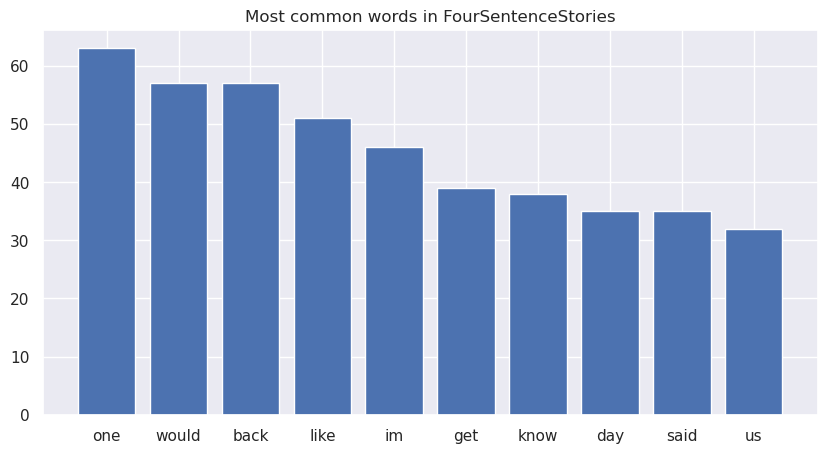

<Figure size 1000x500 with 0 Axes>

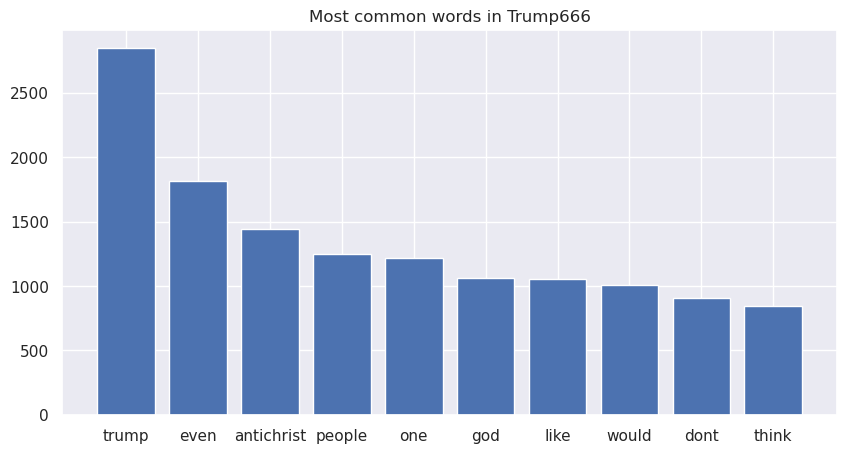

<Figure size 1000x500 with 0 Axes>

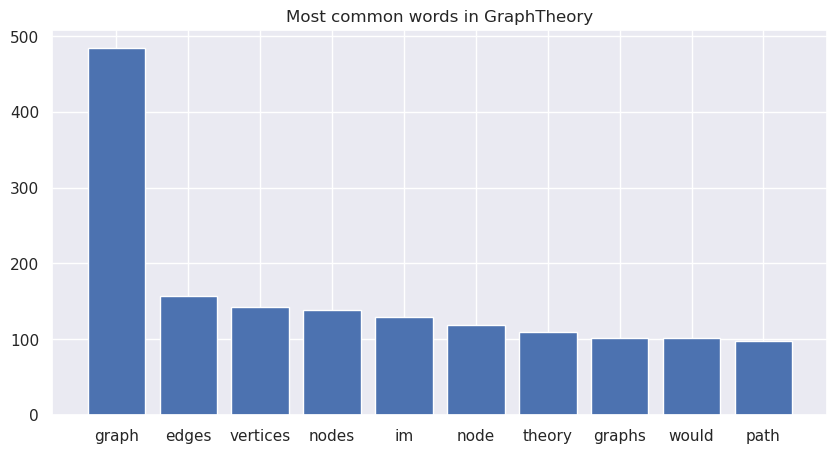

<Figure size 1000x500 with 0 Axes>

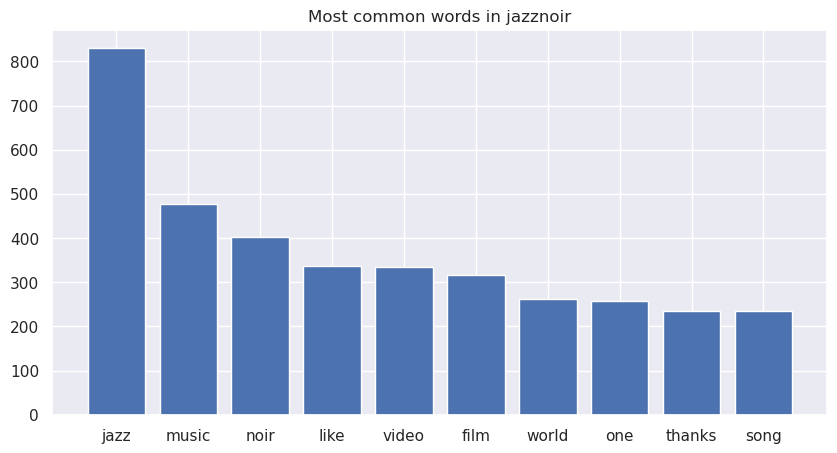

<Figure size 1000x500 with 0 Axes>

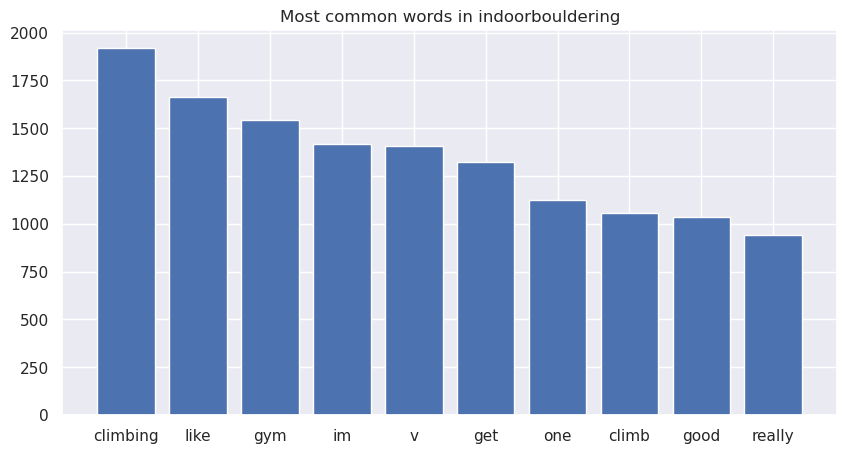

<Figure size 1000x500 with 0 Axes>

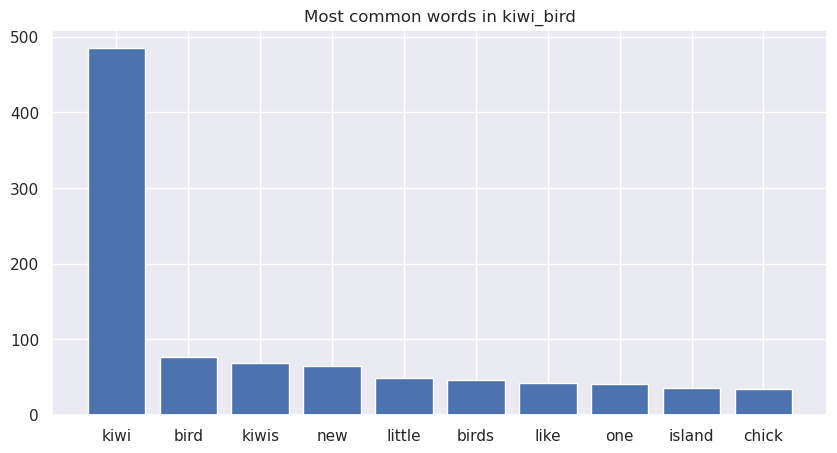

<Figure size 1000x500 with 0 Axes>

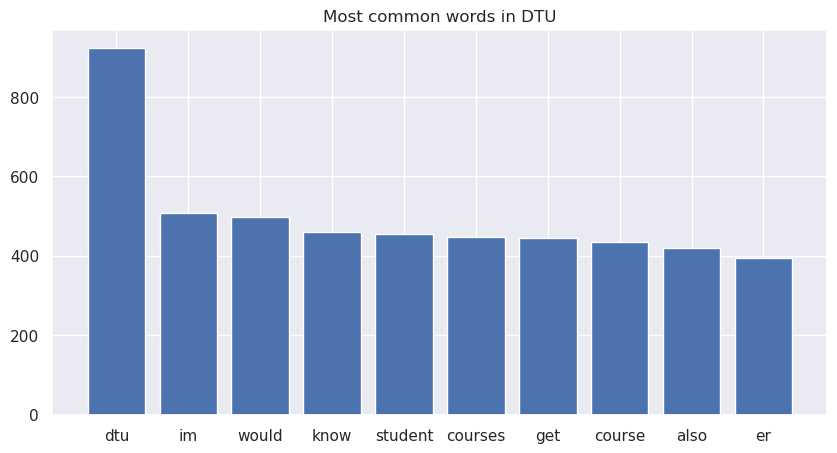

In [8]:
# most said words

stop_words = set(stopwords.words('english'))

def get_most_common_words(df,df_comment, n=10):
    words = []
    df1 = df['text'].apply(lambda x: '' if pd.isna(x) else x) + ' ' + df['title']
    df2 = df_comment['body']
    for text in pd.concat([df1, df2], axis=0):
        if isinstance(text, str):
            text = text.lower()
            text = text.translate(str.maketrans('', '', string.punctuation))
            text = text.translate(str.maketrans('', '', string.digits))
            text = text.translate(str.maketrans('', '', '“'))
            text = text.translate(str.maketrans('', '', '”'))
            text = text.translate(str.maketrans('', '', '’'))
            word_tokens = word_tokenize(text)
            words.extend(word_tokens)
        words = [w for w in words if not w in stop_words]
        word_count = Counter(words)
    return word_count.most_common(n)
    
# get_most_common_words(df_post_dict['Trump666'])

# plot most common words
def plot_most_common_words(df,df_comment, n=10, subreddit=subreddit):
    plt.figure(figsize=(10, 5))
    word_count = get_most_common_words(df, df_comment, n)
    words = [w[0] for w in word_count]
    counts = [w[1] for w in word_count]
    plt.figure(figsize=(10,5))
    plt.bar(words, counts)
    plt.title('Most common words in ' + subreddit)
    plt.show()

for subreddit in subreddits:
    plot_most_common_words(df_post_dict[subreddit], df_comment_dict[subreddit], 10,subreddit)

# TF-IDF

In [38]:
# tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

In [39]:
dfs = []
df_all = pd.DataFrame()

for subreddit in subreddits:
    df = df_post_dict[subreddit]
    df['all_text'] = df['text'].apply(lambda x: '' if pd.isna(x) else x) + ' ' + df['title']
    df['award'] = df_post_dict[subreddit]['award']
    df = df[['all_text', 'award']]

    df_all = pd.concat([df_all, df], axis=0)
    df_all['subreddit'] = subreddit
    # rename df_all column name 0
    dfs.append(df_all)

df_all = pd.concat(dfs, axis=0)

df_all

,all_text,award,subreddit
0,The wolves scratched at the door.\n\nThe smell...,False,FourSentenceStories
1,"He loved me, I know he did. But he also loved ...",False,FourSentenceStories
2,The office lights flickered which broke my wri...,False,FourSentenceStories
3,"""Why not?"" I asked my brother, holding the fla...",False,FourSentenceStories
4,I got a bit closer to the crow and figured it ...,False,FourSentenceStories
...,...,...,...
492,My home university in Canada has cancelled my ...,False,DTU
493,"Hello everyone, I'm an italian student and I'd...",False,DTU
494,"Hi, I will beginn my Master this spring Term a...",False,DTU
495,[removed] Den's fundraiser ®️ https://www.whyd...,False,DTU


In [60]:
# remove all non english words
from nltk.corpus import words
from nltk.stem.porter import PorterStemmer

# stemming
porter = PorterStemmer()
df_all['all_text'] = df_all['all_text'].apply(lambda x: ' '.join([porter.stem(w) for w in x.split()]))

In [56]:
def list_to_string(list):
    string = ''
    for text in list:
        string += text + ' '
    return string

docs = []

for a in [False, True]:
    lis=df_all.loc[df_all['award'] == a]['all_text'].values
    docs.append(list_to_string(lis))

In [57]:
# tf idf with docs
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(docs)
df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
df['award'] = [False, True]
df.head(10)

,00,000,003_pic1,00am,00e80e1fdf43_story,00pm,01,01037,0120,015,...,新宿マッド,杉本拓,欲望リフレクター,殺人の夢,炎のたからもの,運命の門で,重慶森林,青い魂,ｂａｎｋｓ,ｒｉｖｅｒ
0,0.000465,0.003348,0.000058,0.000135,0.000116,0.000406,0.000771,0.000019,0.000116,0.000058,...,0.000077,0.000077,0.000077,0.000077,0.000077,0.000077,0.000077,0.000077,0.000077,0.000077
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003897,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [47]:
tfIdfVectorizer=TfidfVectorizer(use_idf=True,stop_words='english')
tfIdf = tfIdfVectorizer.fit_transform(df_all['all_text'].values)
df = pd.DataFrame(tfIdf[0].T.todense(), index=tfIdfVectorizer.get_feature_names_out(), columns=["TF-IDF"])
df = df.sort_values('TF-IDF', ascending=False)
print (df.head(15))

                TF-IDF
door          0.333829
wolves        0.242093
howled        0.242093
whimpered     0.242093
craved        0.242093
growled       0.242093
transforming  0.229108
allure        0.227126
unmoving      0.225281
stronger      0.217587
smell         0.215038
scratched     0.215038
taste         0.208588
laid          0.201133
flesh         0.188654


# Sentiment

In [12]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [13]:
def get_sentiment(text):
    if type(text) == str:
        com = sia.polarity_scores(text)['compound']
        return com
    else:
        return np.nan


for subreddit in tqdm(subreddits):
    df_post_dict[subreddit]['title_sentiment'] = df_post_dict[subreddit]['title'].apply(lambda x: get_sentiment(x))
    df_post_dict[subreddit]['text_sentiment'] = df_post_dict[subreddit]['text'].apply(lambda x: get_sentiment(x))
    df_comment_dict[subreddit]['sentiment'] = df_comment_dict[subreddit]['body'].apply(lambda x: get_sentiment(x))

100%|██████████| 7/7 [00:05<00:00,  1.32it/s]


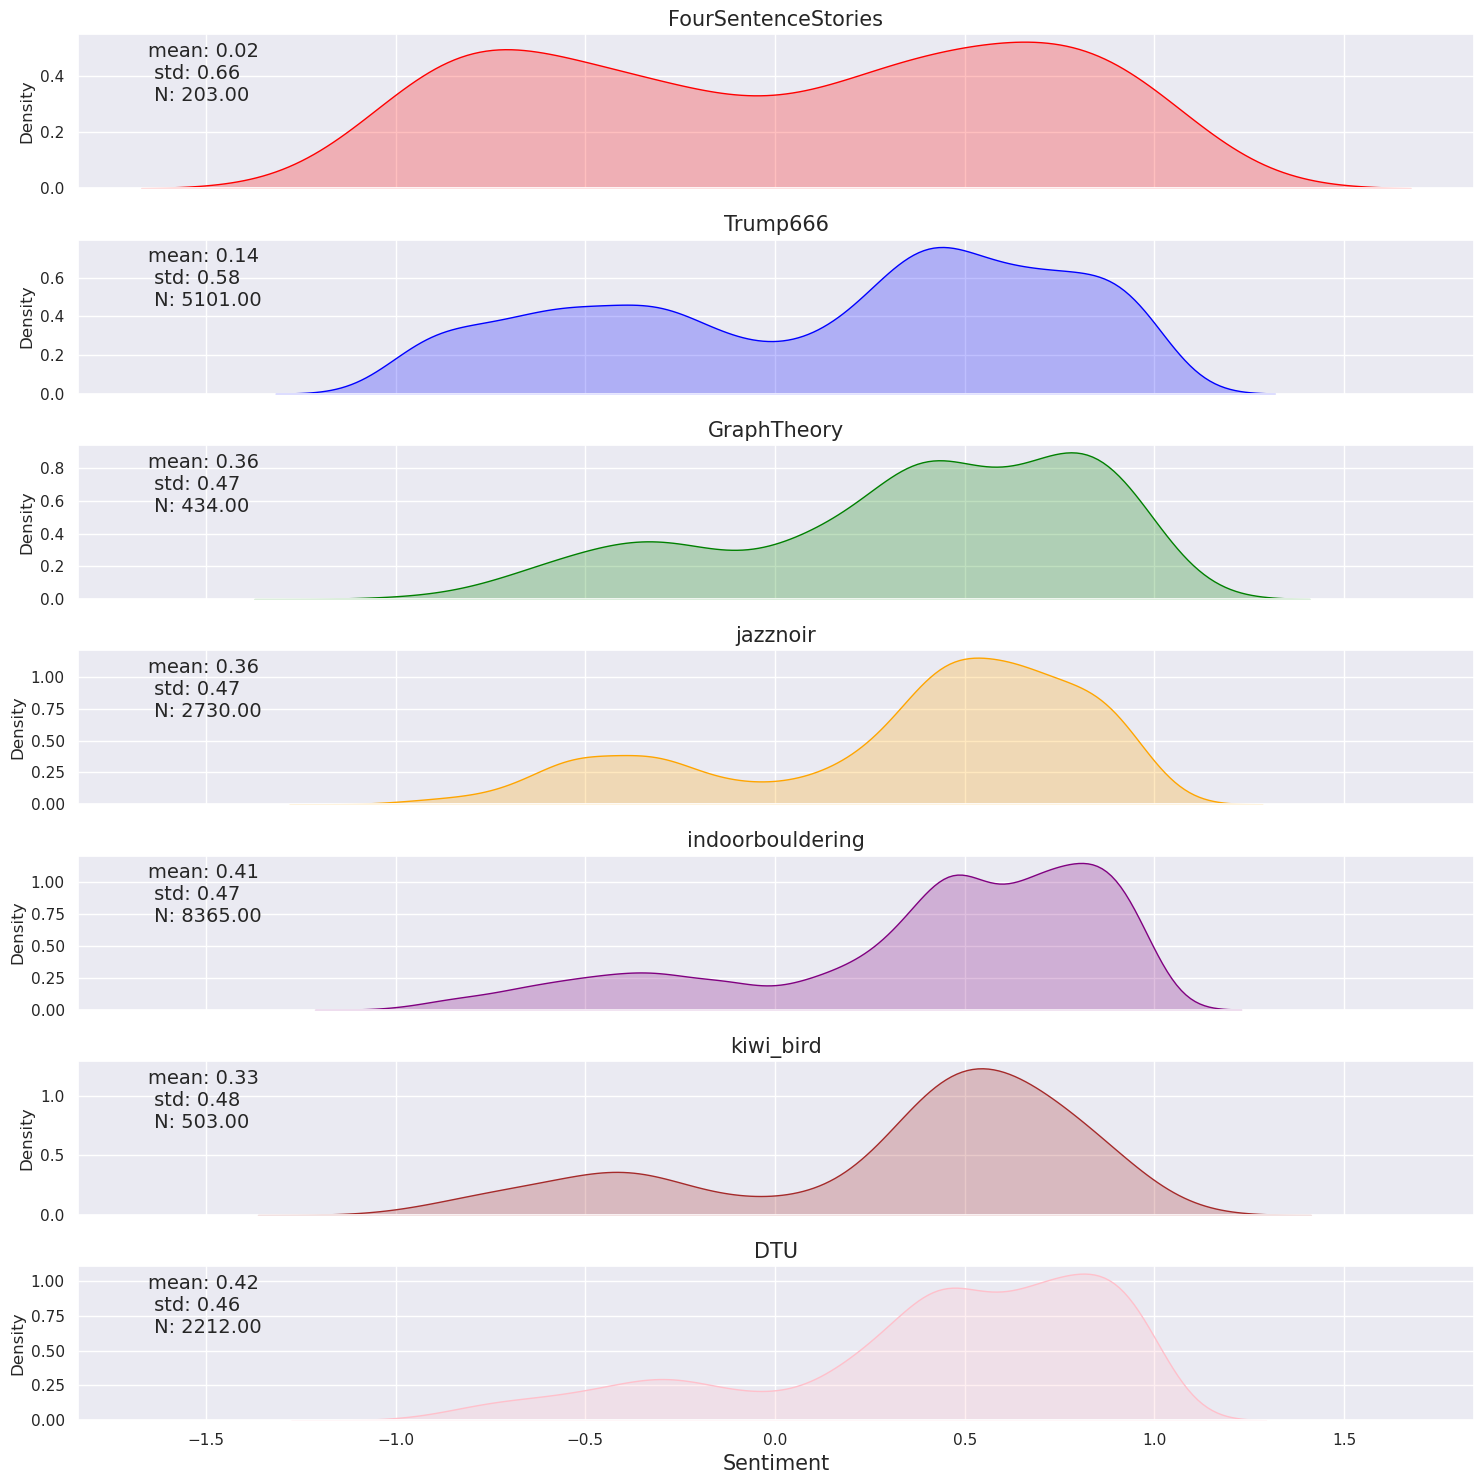

In [139]:
fig, ax = plt.subplots(len(subreddits), 1, figsize=(15, 15), sharex=True)

# color list for each subreddit
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

for i,sub in enumerate(subreddits):

    sentiments=pd.concat([df_post_dict[sub]['title_sentiment'].dropna(),df_comment_dict[sub]['sentiment'].dropna(),df_post_dict[sub]['text_sentiment'].dropna()])
    # drop zero sentiment
    sentiments=sentiments[sentiments!=0]
    # sns.histplot(sentiments, bins=80,kde=True,alpha=0.4, ax=ax[i],color=colors[i],label=sub)
    sns.kdeplot(list(sentiments), ax=ax[i],color=colors[i],label=sub,fill=True)
    ax[i].set_title(sub,fontsize=15)
    # describe sentiment as text on the plot
    ax[i].text(0.05, 0.95, 'mean: {:.2f} \n std: {:.2f} \n N: {:.2f}'.format(sentiments.mean(), sentiments.std(),sentiments.count()), 
    transform=ax[i].transAxes, fontsize=14, verticalalignment='top')    


plt.xlabel('Sentiment',fontsize=15)
plt.tight_layout()
plt.show()

In [15]:
sentiments_a = np.array([])
sentiments_na = np.array([])

for i,sub in enumerate(subreddits):

    sentiments_awarded=pd.concat([
        df_comment_dict[sub].loc[df_comment_dict[sub]['award']==True]['sentiment'].dropna(),
        df_post_dict[sub].loc[df_post_dict[sub]['award']==True]['text_sentiment'].dropna()]).values

    sentiments_not_awarded=pd.concat([
        df_comment_dict[sub].loc[df_comment_dict[sub]['award']==False]['sentiment'].dropna(),
        df_post_dict[sub].loc[df_post_dict[sub]['award']==False]['text_sentiment'].dropna()]).values

    # append to list
    sentiments_a = np.append(sentiments_a, sentiments_awarded)
    sentiments_na = np.append(sentiments_na, sentiments_not_awarded)

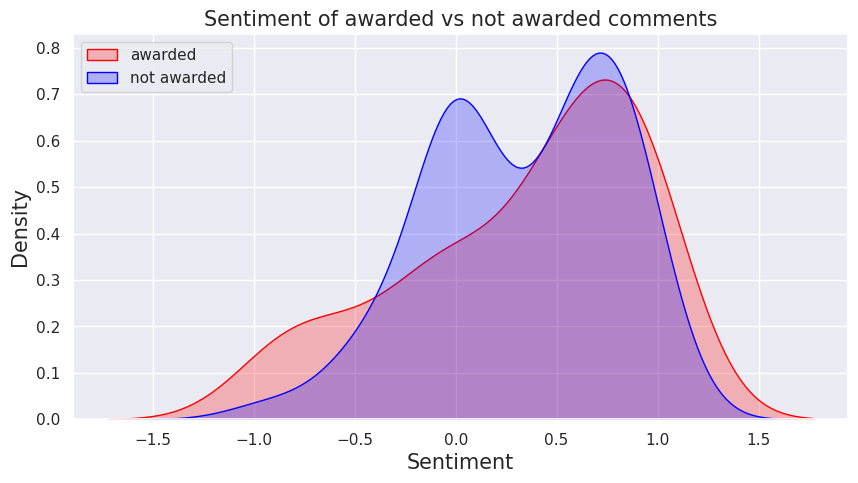

In [36]:
plt.figure(figsize=(10,5))
sentiments_na_sample = np.random.choice(sentiments_na, len(sentiments_a), replace=False)
# plot the 2 kde
sns.kdeplot(list(sentiments_a), color='red',label='awarded',fill=True)
sns.kdeplot(list(sentiments_na_sample), color='blue',label='not awarded',fill=True)
plt.xlabel('Sentiment',fontsize=15)
plt.ylabel('Density',fontsize=15)
plt.legend(loc='upper left')
plt.title('Sentiment of awarded vs not awarded comments',fontsize=15)
plt.show()

# Text length

In [108]:
words_a = np.array([])
words_na = np.array([])

for sub in subreddits:
    post = df_post_dict[sub]
    comment = df_comment_dict[sub]
    post['text'] = post['title'] + ' ' + post['text']
    # get length of text
    lenght = post['text'].apply(lambda x: len(x) if type(x) == str else 0)
    # number of words
    words_a = np.append(words_a, post.loc[post['award']==True]['text'].apply(lambda x: len(x.split()) if type(x) == str else 0).values)
    words_a = np.append(words_a, comment.loc[comment['award']==True]['body'].apply(lambda x: len(x.split()) if type(x) == str else 0).values)

    words_na = np.append(words_na, post.loc[post['award']==False]['text'].apply(lambda x: len(x.split()) if type(x) == str else 0).values)
    words_na = np.append(words_na, comment.loc[comment['award']==False]['body'].apply(lambda x: len(x.split()) if type(x) == str else 0).values)

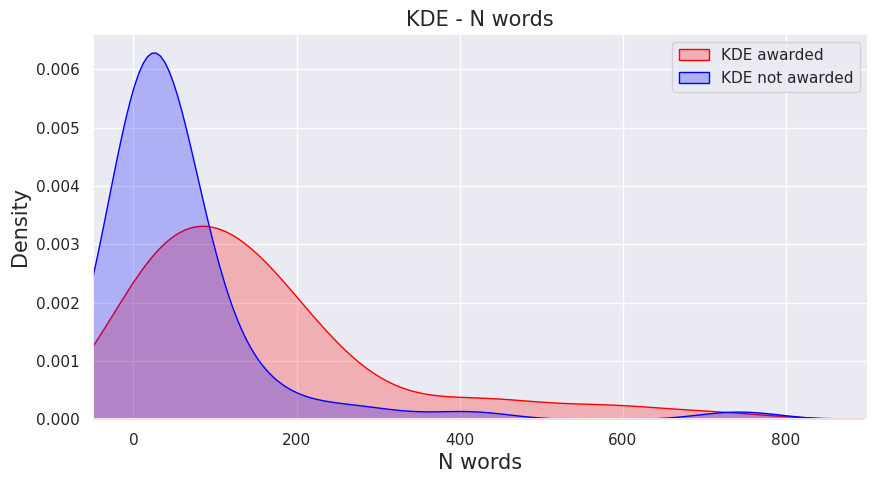

In [143]:
# import norm
from scipy.stats import norm

words_a=words_a[words_a!=0]
words_na=words_na[words_na!=0]

words_na=np.random.choice(words_na, len(words_a), replace=False)

# plot the 2 kde
plt.figure(figsize=(10,5))
sns.kdeplot(words_a, color='red',label='KDE awarded',fill=True)
sns.kdeplot(words_na, color='blue',label='KDE not awarded',fill=True)
plt.title('KDE - N words',fontsize=15)
plt.xlabel('N words',fontsize=15)
plt.ylabel('Density',fontsize=15)
plt.legend(loc='upper right')
plt.xlim(-50,900)
plt.show()